In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

import trino
import mlflow

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import mixed_precision

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

c:\Users\manh\AppData\Local\Programs\Python\Python310\lib\site-packages\google\api_core\_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.11) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    policy = mixed_precision.Policy('mixed_float16')
    print("Using mixed_float16 policy on GPU")
else:
    policy = mixed_precision.Policy('float32')
    print("Using float32 policy on CPU")

mixed_precision.set_global_policy(policy)

Using float32 policy on CPU


In [3]:
conn = trino.dbapi.connect(
    host='localhost', 
    port=8080,               
    user='TrinoPython',          
    catalog='iceberg',         
    schema='gold'           
)

cur = conn.cursor()
cur.execute("""
    SELECT 
            symbol, date, return, 
            body_ratio, upper_ratio, lower_ratio, is_green,
            ema_10_dist_pct, ema_20_dist_pct, rsi_14_scaled, rvol_10,
            label_1, label_2, label_3
    FROM fact_daily_ohlcv
""")

rows = cur.fetchall()
df = pd.DataFrame(rows, columns=[col[0] for col in cur.description])
df = df.sort_values(['symbol', 'date']).reset_index(drop=True)
df

,symbol,date,return,body_ratio,upper_ratio,lower_ratio,is_green,ema_10_dist_pct,ema_20_dist_pct,rsi_14_scaled,rvol_10,label_1,label_2,label_3
0,ACB,2022-01-04,NaN,0.730769,0.000000,0.269231,0,0.000000,0.000000,NaN,1.000000,1.0,1.0,1.0
1,ACB,2022-01-05,-0.020459,0.939394,0.000000,0.060606,0,-0.016801,-0.018546,NaN,1.234857,1.0,1.0,1.0
2,ACB,2022-01-06,0.001899,0.279070,0.279070,0.441860,1,-0.012253,-0.015118,NaN,1.143058,1.0,1.0,1.0
3,ACB,2022-01-07,-0.013266,0.933333,0.066667,0.000000,0,-0.020842,-0.025568,NaN,0.712426,1.0,1.0,1.0
4,ACB,2022-01-10,-0.008963,0.000000,0.857143,0.142857,0,-0.024364,-0.031137,NaN,1.173293,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29455,VRE,2025-12-04,-0.002899,0.307692,0.076923,0.615385,1,0.010865,0.018182,0.657534,0.686792,0.0,0.0,0.0
29456,VRE,2025-12-05,-0.017442,0.521739,0.434783,0.043478,0,-0.005543,0.000383,0.602564,0.846532,0.0,0.0,0.0
29457,VRE,2025-12-08,-0.025148,0.680000,0.200000,0.120000,0,-0.025136,-0.022468,0.535294,0.875848,NaN,NaN,NaN
29458,VRE,2025-12-09,-0.028832,0.452381,0.214286,0.333333,0,-0.043988,-0.046050,0.522989,1.244371,NaN,NaN,NaN


In [4]:
df = df.dropna(inplace=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28950 entries, 14 to 29456
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   symbol           28950 non-null  object 
 1   date             28950 non-null  object 
 2   return           28950 non-null  float64
 3   body_ratio       28950 non-null  float64
 4   upper_ratio      28950 non-null  float64
 5   lower_ratio      28950 non-null  float64
 6   is_green         28950 non-null  int64  
 7   ema_10_dist_pct  28950 non-null  float64
 8   ema_20_dist_pct  28950 non-null  float64
 9   rsi_14_scaled    28950 non-null  float64
 10  rvol_10          28950 non-null  float64
 11  label_1          28950 non-null  float64
 12  label_2          28950 non-null  float64
 13  label_3          28950 non-null  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 3.3+ MB


In [5]:
df.describe()

,return,body_ratio,upper_ratio,lower_ratio,is_green,ema_10_dist_pct,ema_20_dist_pct,rsi_14_scaled,rvol_10,label_1,label_2,label_3
count,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000,28950.000000
mean,0.000471,0.470901,0.257340,0.270412,0.424663,0.001048,0.002192,0.512934,0.985889,1.017893,1.018169,1.017306
std,0.020536,0.295233,0.240693,0.253248,0.494300,0.029813,0.044796,0.178026,0.362467,0.803003,0.753690,0.706956
min,-0.070458,0.000000,0.000000,0.000000,0.000000,-0.199223,-0.277278,0.000000,0.009184,0.000000,0.000000,0.000000
25%,-0.008663,0.222222,0.000000,0.029796,0.000000,-0.012418,-0.018781,0.384615,0.743202,0.000000,0.000000,1.000000
50%,0.000000,0.459459,0.205479,0.214286,0.000000,0.000787,0.001493,0.508677,0.924147,1.000000,1.000000,1.000000
75%,0.009254,0.710109,0.419355,0.437500,1.000000,0.015571,0.024455,0.638901,1.147231,2.000000,2.000000,2.000000
max,0.070833,1.000000,1.000000,1.000000,1.000000,0.180223,0.299401,1.000000,3.863890,2.000000,2.000000,2.000000


# Split to Train/Val Set

In [6]:
val_days = 30 * 4
min_date = pd.to_datetime(df['date'].min())
last_date = pd.to_datetime(df['date'].max())
split_date = last_date - pd.Timedelta(days=val_days)

print(f"Oldest Date: {min_date}")
print(f"Latest Date: {last_date}")
print(f"Date to split train/val: {split_date}")

Oldest Date: 2022-01-24 00:00:00
Latest Date: 2025-12-05 00:00:00
Date to split train/val: 2025-08-07 00:00:00


In [7]:
df.loc[:, 'date'] = pd.to_datetime(df['date'])
df_train = df[df['date'] <= split_date].reset_index(drop=True)
df_val = df[df['date'] > split_date].reset_index(drop=True)

print(f"Train shape: {df_train.shape}")
print(f"Validation shape: {df_val.shape}")

Train shape: (26430, 14)
Validation shape: (2520, 14)


In [8]:
def create_sequences(df: pd.DataFrame, features: list[str], label: str, timesteps: int = 10):
    X_seq_list, y_seq_list = [], []

    for symbol in df['symbol'].unique():
        df_symbol = df[df['symbol'] == symbol].sort_values('date')
        X = df_symbol[features].values
        y = df_symbol[label].values

        for i in range(timesteps, len(X)):
            X_seq_list.append(X[i-timesteps:i])
            y_seq_list.append(y[i-1])

    X_seq = np.array(X_seq_list)
    y_seq = np.array(y_seq_list)

    return X_seq, y_seq

In [9]:
features = [
    'return', 'body_ratio', 'upper_ratio', 'lower_ratio', 'is_green', 
    'ema_10_dist_pct', 'ema_20_dist_pct', 'rsi_14_scaled', "rvol_10"
]

label = "label_2"

In [10]:
X_train, y_train = create_sequences(df_train, features, label)
X_val, y_val = create_sequences(df_val, features, label)

y_train_cat = to_categorical(y_train, num_classes=3)  
y_val_cat = to_categorical(y_val, num_classes=3)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train_cat.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val_cat.shape)

X_train shape: (26130, 10, 9)
y_train shape: (26130, 3)
X_val shape: (2220, 10, 9)
y_val shape: (2220, 3)


# Hanlding Imbalance

In [11]:
np.unique(y_train, return_counts=True)

(array([0., 1., 2.]), array([ 7199, 11155,  7776]))

In [12]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)

class_weights_dict = dict(zip(classes, class_weights))
print(class_weights_dict)

{np.float64(0.0): np.float64(1.2098902625364634), np.float64(1.0): np.float64(0.7808157776781712), np.float64(2.0): np.float64(1.1201131687242798)}


In [13]:
classes, counts = np.unique(y_train, return_counts=True)
total_samples = len(y_train)

weight_1 = total_samples / (len(classes) * counts[classes==1][0])
weight_0 = weight_2 = total_samples / (len(classes) * ((counts[classes==0][0] + counts[classes==2][0])/2))

class_weights_dict = {0: weight_0, 1: weight_1, 2: weight_2}
print(class_weights_dict)

{0: np.float64(1.163272120200334), 1: np.float64(0.7808157776781712), 2: np.float64(1.163272120200334)}


# Model

In [14]:
timesteps = X_train.shape[1]  
n_features = X_train.shape[2]

# Model
model = Sequential([
    Input(shape=(timesteps, n_features)),
    LSTM(64, return_sequences=True),
    LSTM(8, return_sequences=False),
    Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 8)              │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,307 (83.23 KB)

 Trainable params: 21,307 (83.23 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer=Adam(learning_rate=5e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=64,
    class_weight=class_weights_dict,
    callbacks=[early_stop]
)

Epoch 1/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 23s 24ms/step - accuracy: 0.3407 - loss: 1.0985 - val_accuracy: 0.2712 - val_loss: 1.1082
Epoch 2/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.3449 - loss: 1.0973 - val_accuracy: 0.4261 - val_loss: 1.0923
Epoch 3/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3561 - loss: 1.0966 - val_accuracy: 0.3775 - val_loss: 1.0980
Epoch 4/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3621 - loss: 1.0959 - val_accuracy: 0.3176 - val_loss: 1.1035
Epoch 5/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.3590 - loss: 1.0956 - val_accuracy: 0.3946 - val_loss: 1.0934
Epoch 6/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.3711 - loss: 1.0943 - val_accuracy: 0.3797 - val_loss: 1.0976
Epoch 7/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3740 - loss: 1.0932 - val_accuracy: 0.4239 - val_loss: 1.0894
Epoch 8/50
409/409 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.3734 - loss: 1.0922 - val_acc

In [16]:
y_val_cat_pred = model.predict(X_val)
y_val_pred = np.argmax(y_val_cat_pred, axis=1)

70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


In [17]:
print("Classification Report:")
print(classification_report(y_val, y_val_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

         0.0     0.3524    0.3271    0.3393       639
         1.0     0.4729    0.4686    0.4707       986
         2.0     0.3354    0.3664    0.3502       595

    accuracy                         0.4005      2220
   macro avg     0.3869    0.3873    0.3867      2220
weighted avg     0.4014    0.4005    0.4006      2220



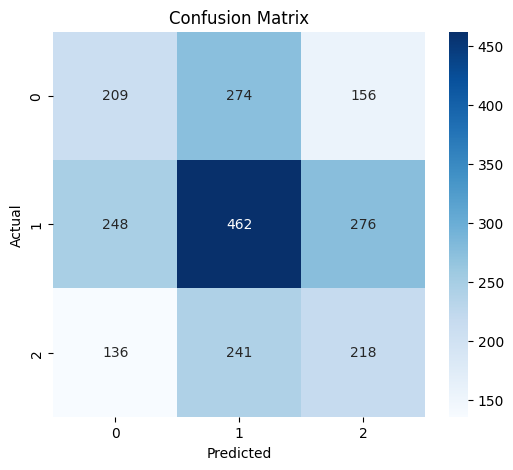

In [18]:
cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [19]:
cm

array([[209, 274, 156],
       [248, 462, 276],
       [136, 241, 218]])